# Gradient 기반 Saliency Map + Feature Map

tf.Tensor([[0.9178693]], shape=(1, 1), dtype=float32)


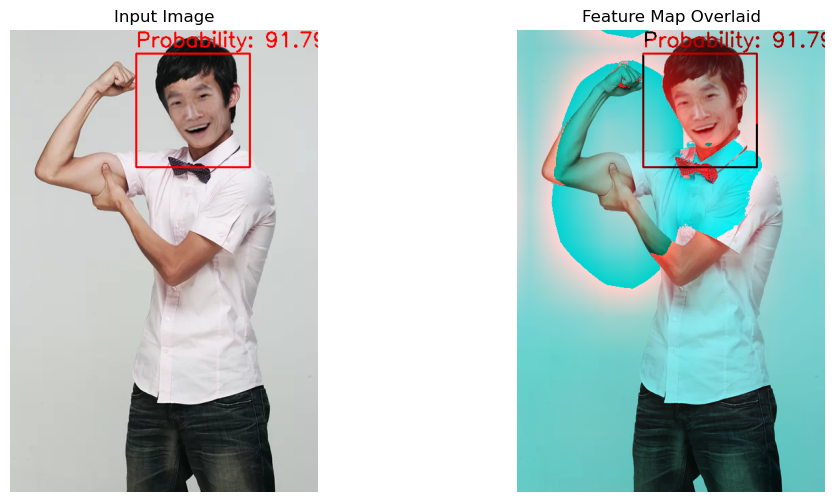

tf.Tensor(0.90536696, shape=(), dtype=float32)


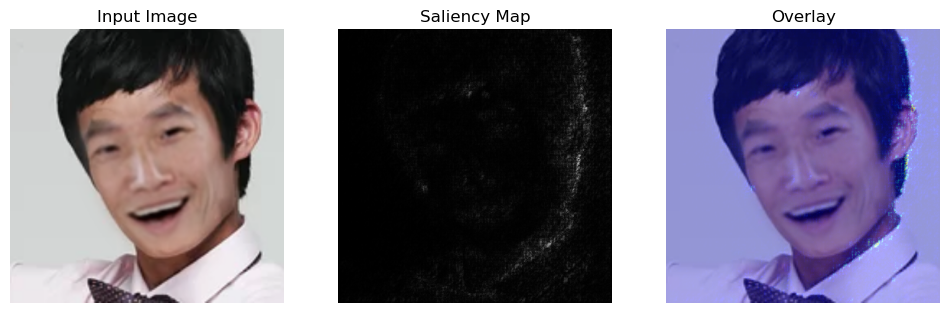

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
import dlib
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib

model = load_model("model_checkpoint_v2.h5")

# 이미지 로드 함수를 정의합니다.
def load_image(image_path):
    try:
        # 이미지를 읽어와서 RGB 형식으로 변환합니다.
        img_arr = cv2.imread(image_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        return img_arr
    except Exception as e:
        raise Exception(f"Error loading image {image_path}: {e}")

# 얼굴 영역을 감지하기 위해 dlib의 얼굴 탐지기 초기화
face_detector = dlib.get_frontal_face_detector()

# 테스트 이미지 로드
test_image_path = "KakaoTalk_20231009_142106119.png"
test_image = load_image(test_image_path)

# 그레이스케일로 변환
gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# 얼굴 영역 감지
faces = face_detector(gray)

# 얼굴이 감지된 경우에만 처리
if len(faces) > 0:
    # 첫 번째 얼굴 영역 선택
    face = faces[0]

    # 얼굴 영역 추출
    left, top, right, bottom = face.left(), face.top(), face.right(), face.bottom()
    margin = int((right - left) * 0.3)
    left -= margin
    top -= margin
    right += margin
    bottom += margin
    face_img = test_image[top:bottom, left:right]

    # 이미지 크기를 모델 입력 크기 (380, 380)으로 조정
    face_img = cv2.resize(face_img, (380, 380))

    # 모델로 예측 수행
    input_data = tf.convert_to_tensor(face_img, dtype=tf.float32)
    input_data = tf.image.resize(input_data, (380, 380))
    input_data = tf.expand_dims(input_data, axis=0)
    predictions = model(input_data)
    print(predictions)
    # 확률 값 추출
    probability = predictions[0][0]  

    # 확률 값을 표시할 텍스트 생성
    text = f'Probability: {probability * 100:.2f}%'

    # 네모 박스 그리기
    cv2.rectangle(test_image, (left, top), (right, bottom), (255, 0, 0), 2)

    # 확률 값을 이미지에 표시
    cv2.putText(test_image, text, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
            # 특성 맵 시각화
    layer_name = "efficientnetb4"  # 원하는 층의 이름을 지정합니다.

    # 해당 층의 출력을 얻습니다.
    layer = model.get_layer(layer_name)
    feature_map = layer(input_data)

    # 시각화를 위해 첫 번째 이미지 (배치 차원)의 결과만 사용합니다.
    feature_map = feature_map[0]

    # 입력 이미지와 특성 맵을 오버랩하여 시각화합니다.
    resized_feature_map = resize(feature_map.numpy().sum(axis=-1), (test_image.shape[0], test_image.shape[1]))
    alpha = 0.5  # 오버랩 투명도 조절
    overlaid_image = test_image.copy()
    overlaid_image[:, :, 0] = (1 - alpha) * overlaid_image[:, :, 0] + alpha * resized_feature_map
    
    # 이미지 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(test_image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(overlaid_image, cmap='jet')
    axes[1].set_title('Feature Map Overlaid')
    axes[1].axis('off')
    plt.show()

else:
    print("No faces detected in the image.")
    
with tf.GradientTape() as tape:
    tape.watch(input_data)
    predictions = model(input_data)
    probability = predictions[0][0]
    print(probability)
gradients = tape.gradient(probability, input_data)
saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)

# Saliency map을 원래 이미지 위에 오버랩하여 시각화
saliency_map_normalized = saliency_map[0] / tf.reduce_max(saliency_map[0])  # 정규화

# Saliency map을 RGB 형식으로 변환하여 오버랩
saliency_map_rgb = cv2.applyColorMap(np.uint8(255 * saliency_map_normalized), cv2.COLORMAP_JET)

# 이미지 오버랩
overlay_image = cv2.addWeighted(cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR), 0.7, saliency_map_rgb, 0.5, 0)

# 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(face_img)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map[0], cmap='gray')
plt.title('Saliency Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title('Overlay')
plt.axis('off')

plt.show()

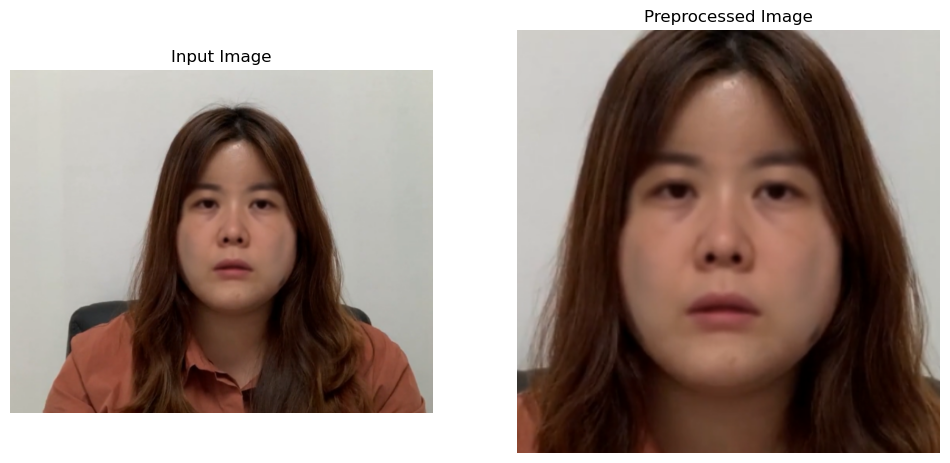

In [4]:
# 테스트 이미지 로드
test_image_path = "test_image5.png"
test_image = load_image(test_image_path)

    # 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(test_image)
axes[0].set_title('Input Image')
axes[0].axis('off')
axes[1].imshow(face_img)
axes[1].set_title('Preprocessed Image')
axes[1].axis('off')
plt.show()
